In [134]:
import PIL,torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from efficientnet_pytorch import EfficientNet

In [87]:
class SkinDataset(Dataset):
    folds=5
    def __init__(self, root , num_classes,fold=0,training=False,n_augment=2):
        self.data_path = []
        self.sides =(224,224)
        self.n_augment = min(n_augment , 4)
        self.root =root
        self.num_classes = num_classes
        self.fold = fold
        if training:
            self.transform = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomAffine(degrees=10),
                transforms.RandomCrop(size=self.sides),
                transforms.ToTensor(),
                transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(self.sides),
                transforms.ToTensor(),
                transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
            ])
        self.training = training
        self.restoreDataset()

    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        img = Image.open(ddir)
        imgmat = self.transform(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        if self.training:
            return len(self.data_path)*self.n_augment
        else:
            return len(self.data_path)
    def specialDataset(self, weak_classes):
        '''
            weak_classes ; set of reserve label
        '''
        self.data_path=[]
        fold = self.fold
        for label in weak_classes:
            data_dir = os.path.join(self.root,os.listdir(self.root)[label])
            file_name = os.listdir(data_dir)
            l = len(file_name)
            inter = l//SkinDataset.folds
            picked = list(range(inter* fold,inter * (fold+1))) if not self.training else list(range(0,inter*fold))+list(range(inter*(fold+1),l))

            for i in picked:
                file_path = os.path.join(data_dir , file_name[i])
#                 img = Image.open(fil)
                self.data_path.append((file_path, label))

    def restoreDataset(self):
        self.specialDataset(range(self.num_classes))


In [122]:
class NormalSkinDataset(Dataset):
    # only for training
    def __init__(self, root , n_augment=2):
        self.data_path = []
        self.sides =(224,224)
        self.n_augment = min(n_augment , 4)
        self.root =root
        self.transform = transforms.Compose([
            transforms.Resize((288, 288)),
            transforms.RandomAffine(degrees=10),
            transforms.RandomCrop(size=self.sides),
            transforms.ToTensor(),
            transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
        ])

        data_dir = self.root
        file_name = os.listdir(data_dir)
        l = len(file_name)

        for i in range(l):
            file_path = os.path.join(data_dir , file_name[i])
#                 img = Image.open(fil)
            self.data_path.append((file_path, -1))


    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        # label is forced to -1
        img = Image.open(ddir)
        imgmat = self.transform(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        return len(self.data_path)*self.n_augment

(tensor([[[-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
         [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
         [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
         ...,
         [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
         [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
         [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877]],

        [[-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
         [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
         [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
         ...,
         [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
         [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
         [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715]],

        [[-2.1025, -2.1025, -2.1025,  ..., -2.1025, -2.1025, -2.1025],
         [-2.1025, -2.1025, -2.1025,  ..., -

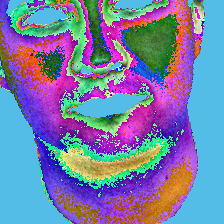

In [100]:
img_id = 7
print(negative_dataset[img_id])
transforms.ToPILImage()(negative_dataset[img_id][0])

In [123]:
# del training_dataloader
batch_size = 32
training_dataset = SkinDataset(os.path.join(os.getcwd(),'../Skin40'), 40, training=True)
test_dataset = SkinDataset(os.path.join(os.getcwd(),'../Skin40'), 40)
training_dataloader = DataLoader(training_dataset , batch_size = batch_size , num_workers = 2, shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , num_workers = 2, shuffle = True)
negative_dataset = NormalSkinDataset(os.path.join(os.getcwd(),'../masked'), n_augment=2)
negative_dataloader = DataLoader(negative_dataset, batch_size=batch_size , num_workers=2 , shuffle=True)

In [124]:
len(negative_dataset)/2

76.0

In [ ]:
img_id = 8
for i in range(len(negative_dataset.data_path)):
    print(negative_dataset.data_path[i])
    print(negative_dataset.__getitem__(i))

In [ ]:
for i, label in enumerate(os.listdir(test_dataset.root)):
    print(i,label,end='\t')

In [46]:
test_dataset.data_path[181]

('/home/jovyan/Documents/dataset_skin40/SYSUDeepLearningSkin/../Skin40/Nevus_Incipiens/010576HB.jpg',
 15)

In [ ]:
img_id = 456
print(test_dataset[img_id])
transforms.ToPILImage()(test_dataset[img_id][0])

In [135]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every 100 iteration, print loss
        if (i + 1) % 50 == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

def train_negative(model, train_loader, optimizer, device):
    """
    train model using optimizer in an epoch in negative training
    model: CNN networks
    train_loader: a Dataloader object with training data
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    loss_eps = 1e-6
    # train the model using minibatch wih mini batch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        
        # forward
        outputs = model(images)
#         print(outputs+loss_eps, torch.log(outputs+loss_eps),outputs.shape)
        loss = -torch.log(F.softmax(outputs,dim=1)).mean()

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every 100 iteration, print loss
        if (i + 1) % 50 == 0:
            print ("Step [{}/{}] Train_negative Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))

    print('Global neg-train loss: {:.4f}'. format(total_loss / len(train_loader)))
    return total_loss / len(train_loader)

In [125]:
def evaluate(model, val_loader, device, nclasses):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        cm = torch.zeros(nclasses, nclasses)
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                cm[t.long()][p.long()] +=1
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        show_heatmap(cm, nclasses)
        return accuracy

In [126]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

def show_heatmap(cm, nclasses):
    labels = range(nclasses)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    
    im = ax.imshow(cm, cmap=plt.cm.hot_r )
    plt.colorbar(im)
    plt.title("Confusioin Matrix")
    plt.show()
    print('Accuracy of each class:\n', cm.diag()/(cm.sum(1)+1e-6))
    print('Recall of each class:\n', cm.diag()/(cm.sum(0)+1e-6))

In [144]:
def fit(model, num_epochs, optimizer, schedulr, device,nclasses,nega_only=False):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)
        schedulr: scheduling learning rate

    """
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}: , lr = {}'.format(epoch + 1, num_epochs , optimizer.param_groups[0]['lr']))
        # train step
        if not nega_only:
            loss = train(model, training_dataloader, loss_func, optimizer, device)
            losses.append(loss)
        neg_loss = train_negative(model,negative_dataloader, optimizer, device)
        schedulr.step()
        
        # evaluate step
        accuracy = evaluate(model, test_dataloader, device,nclasses)
        accs.append(accuracy)
        
    
    # show curve
    if not nega_only:
        show_curve(losses, "train loss")
        show_curve(accs, "test accuracy")

In [141]:
net = EfficientNet.from_pretrained('efficientnet-b7')
net._fc = torch.nn.Sequential(nn.Linear(2560, 4096),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.6),
                             nn.Linear(4096, 4096),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.5),
                             nn.Linear(4096, 40)
                            )

Loaded pretrained weights for efficientnet-b7


In [19]:
netdict = torch.load('../baseEffi_chk0.pth')
net.load_state_dict(netdict['state_dict'])

<All keys matched successfully>

In [161]:
# Hyper-parameters
num_epochs = 10
lr =5e-3
nclasses = 40
feature_tune=True
# Device configuration
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

for parma in net.parameters():
    parma.requires_grad = feature_tune
# for param in net._bn1.parameters():
#     param.requires_grad = feature_tune
# for param in net._conv_head.parameters():
#     param.requires_grad = feature_tune
# for param in net._blocks[-1].parameters():
#     param.requires_grad = feature_tune    
for param in net._fc.parameters():
    param.requires_grad = True
# # optimizer
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 1 , gamma = 0.99)
# for name,param in net.named_parameters():
#     print(param.requires_grad, name)

Epoch 1/10: , lr = 0.005
Step [50/120] Train Loss: 0.0835
Step [100/120] Train Loss: 0.0434
Global neg-train loss: 4.4585
Accuracy on Test Set: 62.2917 %


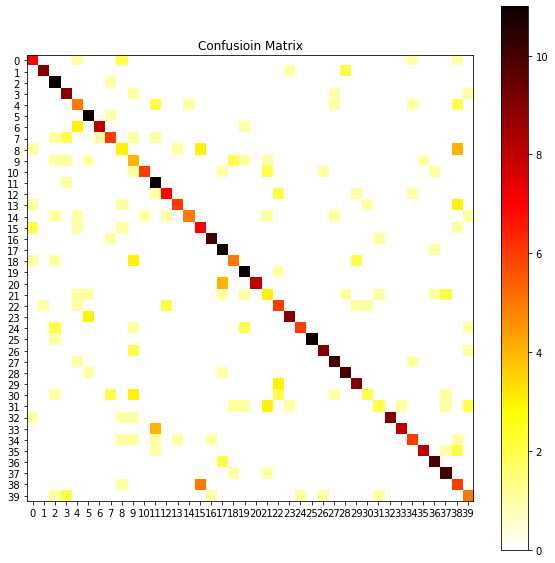

Accuracy of each class:
 tensor([0.5833, 0.7500, 0.9167, 0.7500, 0.4167, 0.9167, 0.6667, 0.5000, 0.2500,
        0.3333, 0.5000, 0.9167, 0.5833, 0.5000, 0.4167, 0.5833, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.2500, 0.5000, 0.7500, 0.5000, 0.9167, 0.7500,
        0.8333, 0.8333, 0.7500, 0.1667, 0.1667, 0.7500, 0.6667, 0.5000, 0.6667,
        0.8333, 0.8333, 0.5000, 0.4167])
Recall of each class:
 tensor([0.5385, 0.9000, 0.5500, 0.6000, 0.3571, 0.6471, 0.8889, 0.5455, 0.3000,
        0.2222, 0.8571, 0.5238, 0.7000, 0.7500, 0.8333, 0.4667, 0.8333, 0.5500,
        0.5556, 0.6471, 1.0000, 0.2727, 0.4286, 0.8182, 0.8571, 1.0000, 0.8182,
        0.7143, 0.7692, 0.6923, 0.5000, 0.4000, 1.0000, 0.8889, 0.6000, 0.8889,
        0.7692, 0.6667, 0.3000, 0.4545])
Epoch 2/10: , lr = 0.00495
Step [50/120] Train Loss: 0.0601
Step [100/120] Train Loss: 0.0453
Global neg-train loss: 4.4879
Accuracy on Test Set: 62.0833 %


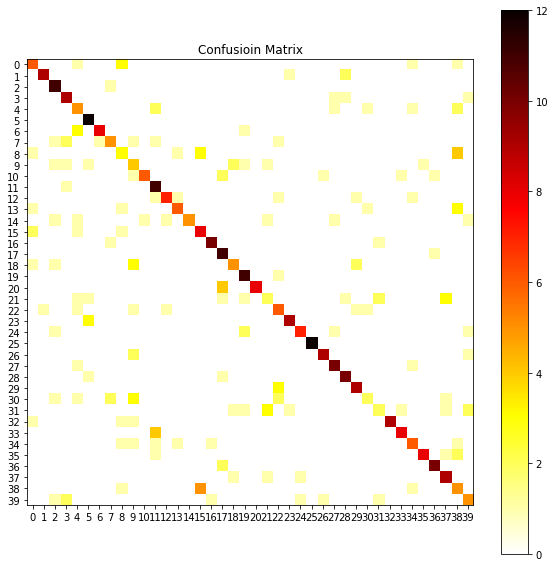

Accuracy of each class:
 tensor([0.5000, 0.7500, 0.9167, 0.7500, 0.4167, 1.0000, 0.6667, 0.4167, 0.2500,
        0.3333, 0.5000, 0.9167, 0.5833, 0.5000, 0.4167, 0.6667, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.1667, 0.5000, 0.7500, 0.5833, 1.0000, 0.7500,
        0.8333, 0.8333, 0.7500, 0.1667, 0.1667, 0.7500, 0.6667, 0.5000, 0.6667,
        0.8333, 0.7500, 0.4167, 0.4167])
Recall of each class:
 tensor([0.5000, 0.9000, 0.6111, 0.6000, 0.3333, 0.6667, 0.8889, 0.5556, 0.2727,
        0.2353, 0.8571, 0.5238, 0.7778, 0.6667, 1.0000, 0.5000, 0.8333, 0.5238,
        0.5556, 0.6471, 1.0000, 0.2500, 0.4286, 0.8182, 0.7778, 1.0000, 0.8182,
        0.7143, 0.7143, 0.6923, 0.4000, 0.3333, 1.0000, 0.8000, 0.5455, 0.8889,
        0.8333, 0.6000, 0.2778, 0.4545])
Epoch 3/10: , lr = 0.0049005
Step [50/120] Train Loss: 0.0612
Step [100/120] Train Loss: 0.1320
Global neg-train loss: 4.4331
Accuracy on Test Set: 62.2917 %


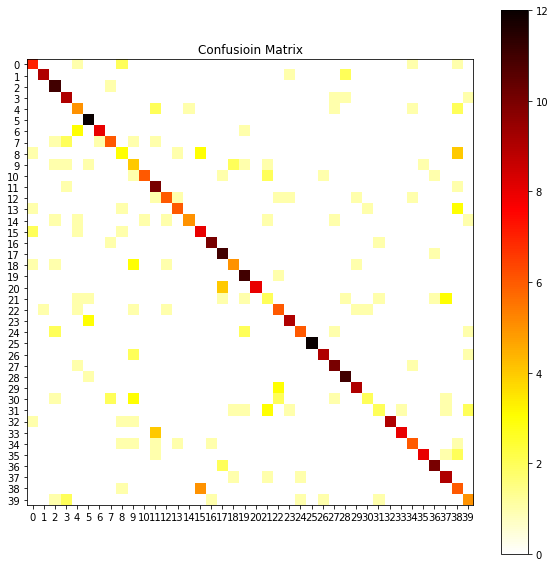

Accuracy of each class:
 tensor([0.5833, 0.7500, 0.9167, 0.7500, 0.4167, 1.0000, 0.6667, 0.5000, 0.2500,
        0.3333, 0.5000, 0.8333, 0.5000, 0.5000, 0.4167, 0.6667, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.1667, 0.5000, 0.7500, 0.5000, 1.0000, 0.7500,
        0.8333, 0.9167, 0.7500, 0.1667, 0.1667, 0.7500, 0.6667, 0.5000, 0.6667,
        0.8333, 0.7500, 0.5000, 0.4167])
Recall of each class:
 tensor([0.5385, 0.9000, 0.5789, 0.6000, 0.3571, 0.6667, 0.8889, 0.6000, 0.3000,
        0.2353, 0.8571, 0.5000, 0.6667, 0.6667, 0.8333, 0.5000, 0.8333, 0.5789,
        0.5556, 0.6471, 1.0000, 0.2000, 0.4615, 0.7500, 0.7500, 1.0000, 0.8182,
        0.6667, 0.7333, 0.7500, 0.5000, 0.4000, 1.0000, 0.8889, 0.6000, 0.8889,
        0.7692, 0.6000, 0.3000, 0.4545])
Epoch 4/10: , lr = 0.004851495
Step [50/120] Train Loss: 0.0405
Step [100/120] Train Loss: 0.0587
Global neg-train loss: 4.4056
Accuracy on Test Set: 62.7083 %


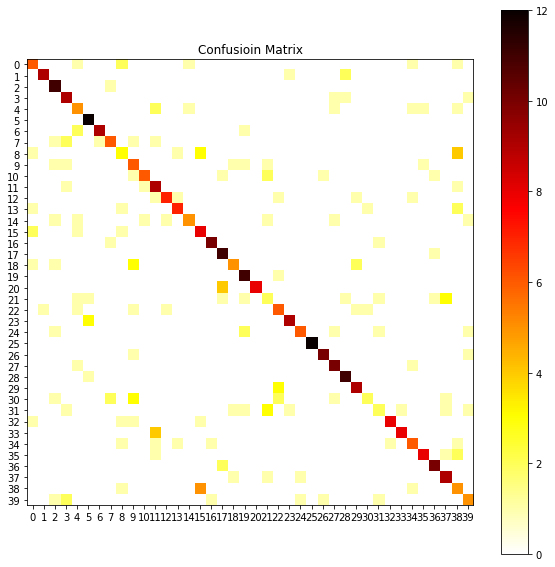

Accuracy of each class:
 tensor([0.5000, 0.7500, 0.9167, 0.7500, 0.4167, 1.0000, 0.7500, 0.5000, 0.2500,
        0.5000, 0.5000, 0.7500, 0.5833, 0.5833, 0.4167, 0.6667, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.1667, 0.5000, 0.7500, 0.5000, 1.0000, 0.8333,
        0.8333, 0.9167, 0.7500, 0.1667, 0.1667, 0.6667, 0.6667, 0.5000, 0.6667,
        0.8333, 0.7500, 0.4167, 0.4167])
Recall of each class:
 tensor([0.5000, 0.9000, 0.6111, 0.5625, 0.3846, 0.7059, 0.9000, 0.6000, 0.3000,
        0.3529, 0.7500, 0.4737, 0.7778, 0.7000, 0.7143, 0.4706, 0.8333, 0.5789,
        0.6250, 0.6471, 1.0000, 0.2000, 0.4615, 0.8182, 0.7500, 1.0000, 0.8333,
        0.6667, 0.7333, 0.6923, 0.5000, 0.3333, 0.8889, 0.8889, 0.5455, 0.8000,
        0.7692, 0.6000, 0.2941, 0.5000])
Epoch 5/10: , lr = 0.00480298005
Step [50/120] Train Loss: 0.1153
Step [100/120] Train Loss: 0.0369
Global neg-train loss: 4.2837
Accuracy on Test Set: 62.5000 %


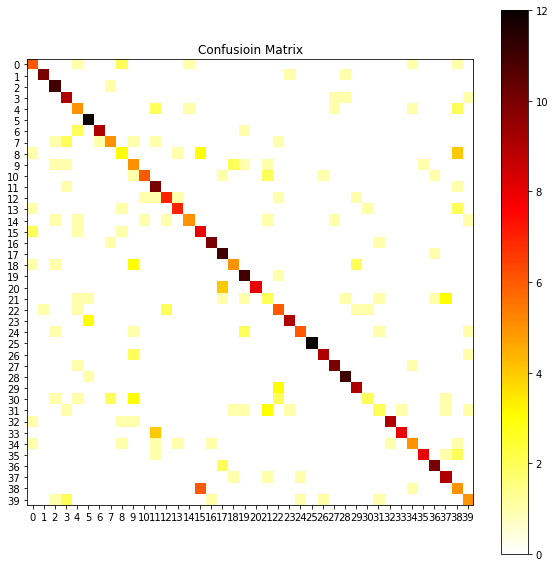

Accuracy of each class:
 tensor([0.5000, 0.8333, 0.9167, 0.7500, 0.4167, 1.0000, 0.7500, 0.4167, 0.2500,
        0.4167, 0.5000, 0.8333, 0.5833, 0.5833, 0.4167, 0.6667, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.1667, 0.5000, 0.7500, 0.5000, 1.0000, 0.7500,
        0.8333, 0.9167, 0.7500, 0.1667, 0.1667, 0.7500, 0.6667, 0.4167, 0.6667,
        0.8333, 0.7500, 0.4167, 0.4167])
Recall of each class:
 tensor([0.4615, 0.9091, 0.6111, 0.5625, 0.3571, 0.7059, 0.9000, 0.5556, 0.3333,
        0.2941, 0.7500, 0.5000, 0.7000, 0.7000, 0.7143, 0.4706, 0.8333, 0.5789,
        0.5556, 0.6471, 1.0000, 0.2000, 0.4286, 0.8182, 0.7500, 1.0000, 0.8182,
        0.7692, 0.7857, 0.6923, 0.5000, 0.3333, 0.9000, 0.8889, 0.5556, 0.8889,
        0.7692, 0.6000, 0.2778, 0.5000])
Epoch 6/10: , lr = 0.0047549502495
Step [50/120] Train Loss: 0.1163
Step [100/120] Train Loss: 0.0276
Global neg-train loss: 4.3980
Accuracy on Test Set: 62.7083 %


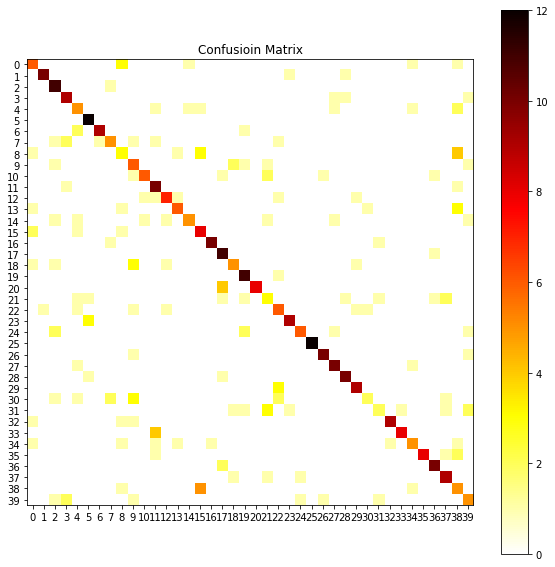

Accuracy of each class:
 tensor([0.5000, 0.8333, 0.9167, 0.7500, 0.4167, 1.0000, 0.7500, 0.4167, 0.2500,
        0.5000, 0.5000, 0.8333, 0.5833, 0.5000, 0.4167, 0.6667, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.2500, 0.5000, 0.7500, 0.5000, 1.0000, 0.8333,
        0.8333, 0.8333, 0.7500, 0.1667, 0.1667, 0.7500, 0.6667, 0.4167, 0.6667,
        0.8333, 0.7500, 0.4167, 0.4167])
Recall of each class:
 tensor([0.4615, 0.9091, 0.5789, 0.6429, 0.3846, 0.7059, 0.9000, 0.5556, 0.2727,
        0.3333, 0.7500, 0.5263, 0.7000, 0.6667, 0.7143, 0.4706, 0.9091, 0.5500,
        0.5556, 0.6471, 1.0000, 0.2727, 0.4286, 0.8182, 0.7500, 1.0000, 0.8333,
        0.7143, 0.7692, 0.7500, 0.5000, 0.4000, 0.9000, 0.8889, 0.5556, 1.0000,
        0.7692, 0.6429, 0.2632, 0.4167])
Epoch 7/10: , lr = 0.004707400747005
Step [50/120] Train Loss: 0.0114
Step [100/120] Train Loss: 0.0840
Global neg-train loss: 4.3129
Accuracy on Test Set: 62.5000 %


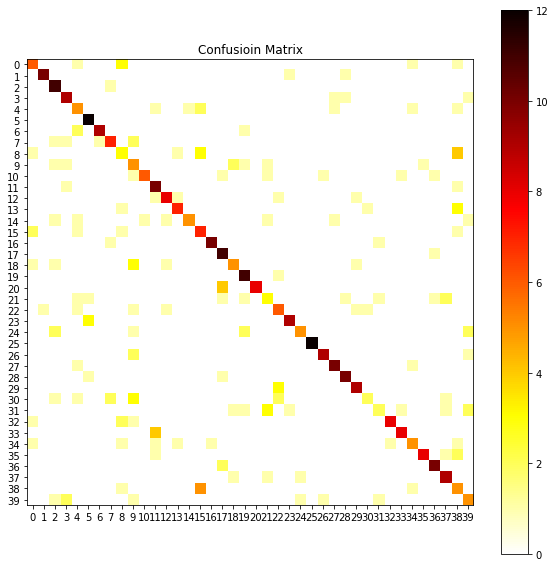

Accuracy of each class:
 tensor([0.5000, 0.8333, 0.9167, 0.7500, 0.4167, 1.0000, 0.7500, 0.5833, 0.2500,
        0.4167, 0.5000, 0.8333, 0.6667, 0.5833, 0.4167, 0.5833, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.2500, 0.5000, 0.7500, 0.4167, 1.0000, 0.7500,
        0.8333, 0.8333, 0.7500, 0.1667, 0.1667, 0.6667, 0.6667, 0.4167, 0.6667,
        0.8333, 0.7500, 0.4167, 0.4167])
Recall of each class:
 tensor([0.5000, 0.9091, 0.5789, 0.6429, 0.3571, 0.7059, 0.9000, 0.6364, 0.2500,
        0.2500, 0.8571, 0.5556, 0.7273, 0.7000, 0.8333, 0.4118, 0.9091, 0.5500,
        0.5556, 0.6471, 1.0000, 0.3000, 0.4615, 0.8182, 0.7143, 1.0000, 0.8182,
        0.7692, 0.7692, 0.7500, 0.5000, 0.4000, 0.8889, 0.8000, 0.5556, 0.8889,
        0.7692, 0.6429, 0.2632, 0.4167])
Epoch 8/10: , lr = 0.00466032673953495
Step [50/120] Train Loss: 0.0270
Step [100/120] Train Loss: 0.1512
Global neg-train loss: 4.3421
Accuracy on Test Set: 62.7083 %


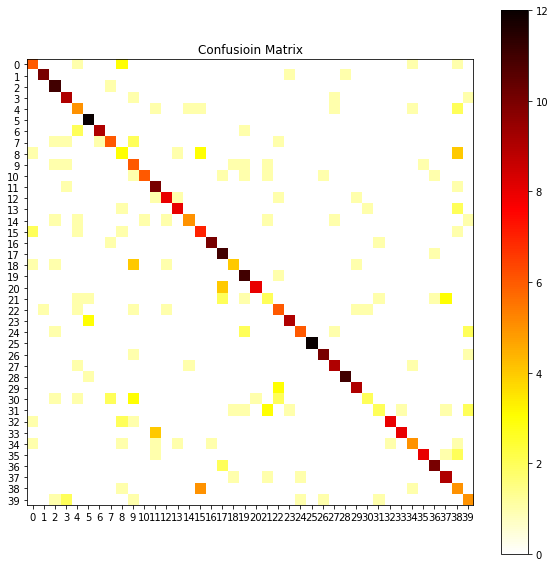

Accuracy of each class:
 tensor([0.5000, 0.8333, 0.9167, 0.7500, 0.4167, 1.0000, 0.7500, 0.5000, 0.2500,
        0.5000, 0.5000, 0.8333, 0.6667, 0.6667, 0.4167, 0.5833, 0.8333, 0.9167,
        0.3333, 0.9167, 0.6667, 0.1667, 0.5000, 0.7500, 0.5000, 1.0000, 0.8333,
        0.7500, 0.9167, 0.7500, 0.1667, 0.1667, 0.6667, 0.6667, 0.4167, 0.6667,
        0.8333, 0.7500, 0.4167, 0.4167])
Recall of each class:
 tensor([0.5000, 0.9091, 0.6111, 0.6429, 0.3571, 0.7059, 0.9000, 0.6000, 0.2500,
        0.2857, 0.8571, 0.5556, 0.7273, 0.7273, 0.7143, 0.4375, 0.9091, 0.5500,
        0.5714, 0.6111, 0.8889, 0.2222, 0.4286, 0.8182, 0.7500, 1.0000, 0.8333,
        0.6923, 0.9167, 0.7500, 0.5000, 0.4000, 0.8889, 0.8889, 0.5556, 0.8889,
        0.7692, 0.6429, 0.2632, 0.4167])
Epoch 9/10: , lr = 0.0046137234721396
Step [50/120] Train Loss: 0.0525
Step [100/120] Train Loss: 0.0426
Global neg-train loss: 4.3103
Accuracy on Test Set: 62.2917 %


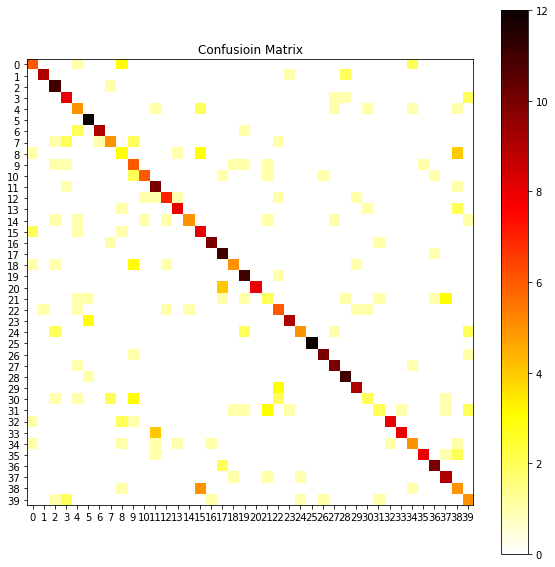

Accuracy of each class:
 tensor([0.5000, 0.7500, 0.9167, 0.6667, 0.4167, 1.0000, 0.7500, 0.4167, 0.2500,
        0.5000, 0.5000, 0.8333, 0.5833, 0.6667, 0.4167, 0.6667, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.1667, 0.5000, 0.7500, 0.4167, 1.0000, 0.8333,
        0.8333, 0.9167, 0.7500, 0.1667, 0.1667, 0.6667, 0.6667, 0.4167, 0.6667,
        0.8333, 0.7500, 0.4167, 0.4167])
Recall of each class:
 tensor([0.5000, 0.9000, 0.5789, 0.5714, 0.3571, 0.7059, 0.9000, 0.5556, 0.2500,
        0.3333, 0.7500, 0.5556, 0.7000, 0.7273, 0.8333, 0.4444, 0.8333, 0.5789,
        0.6250, 0.6471, 1.0000, 0.2222, 0.4286, 0.8182, 0.7143, 1.0000, 0.8333,
        0.7143, 0.7333, 0.7500, 0.4000, 0.4000, 0.8889, 0.8889, 0.5000, 0.8889,
        0.7692, 0.6000, 0.3125, 0.3846])
Epoch 10/10: , lr = 0.004567586237418204
Step [50/120] Train Loss: 0.1110
Step [100/120] Train Loss: 0.0468
Global neg-train loss: 4.3320
Accuracy on Test Set: 62.5000 %


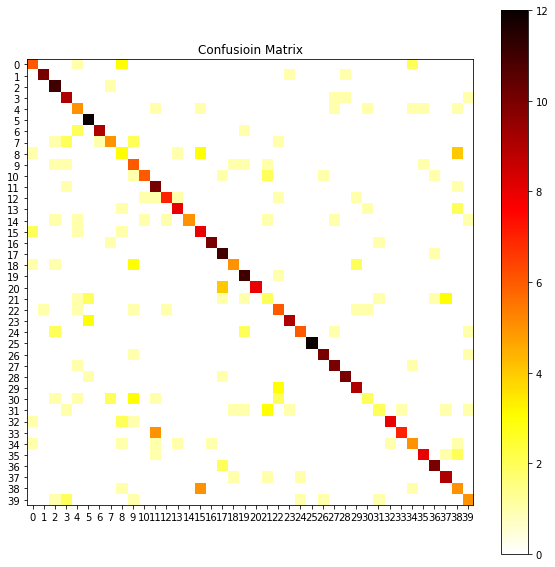

Accuracy of each class:
 tensor([0.5000, 0.8333, 0.9167, 0.7500, 0.4167, 1.0000, 0.7500, 0.4167, 0.2500,
        0.5000, 0.5000, 0.8333, 0.5833, 0.6667, 0.4167, 0.6667, 0.8333, 0.9167,
        0.4167, 0.9167, 0.6667, 0.1667, 0.5000, 0.7500, 0.5000, 1.0000, 0.8333,
        0.8333, 0.8333, 0.7500, 0.1667, 0.1667, 0.6667, 0.5833, 0.4167, 0.6667,
        0.8333, 0.7500, 0.4167, 0.4167])
Recall of each class:
 tensor([0.5000, 0.9091, 0.5789, 0.5625, 0.3571, 0.6667, 0.9000, 0.5556, 0.2500,
        0.3158, 0.7500, 0.5000, 0.7778, 0.7273, 1.0000, 0.4706, 0.9091, 0.5500,
        0.6250, 0.6471, 1.0000, 0.2000, 0.4286, 0.8182, 0.7500, 1.0000, 0.8333,
        0.7143, 0.8333, 0.6923, 0.4000, 0.4000, 0.8889, 0.8750, 0.5000, 0.8000,
        0.7692, 0.6429, 0.3125, 0.5000])


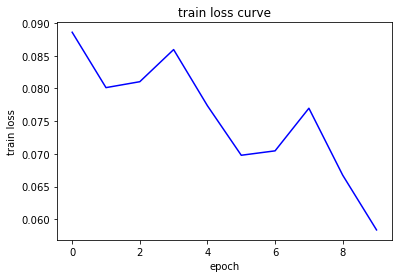

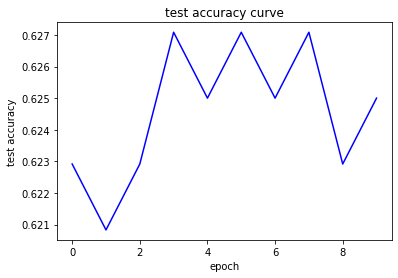

In [162]:
# num_epochs = 5
# schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 1 , gamma = 0.9)
fit(net, num_epochs, optimizer, schedulr,device, nclasses,nega_only=False)  #

In [19]:
torch.save({'epoch':12 , 'state_dict':net.state_dict()}, '../baseEffi_chk1.pth')

In [ ]:
net.to(device)
evaluate(net, test_dataloader, device, nclasses)

In [23]:
1+2

3

In [85]:
training_dataset[0][0].shape

torch.Size([3, 224, 224])

In [86]:
negative_dataset[0][0].shape

torch.Size([3, 224, 224])